https://wecandev.tistory.com/109

https://sup2is.github.io/2020/06/08/kafka-connect-example.html

 본 블로그를 이용하여 공부하였음:

Kafka connect=> 데이터 통합 프레임 워크  
Kafka connect => Kafka_connector가 동작하도록 실행해주는 프로세스 

Kafka connect 에는 Source connector 와 Sink connector가 있음 

요약 : Source Connector는 Producer의 역할
       Sink connector는 Consumer의 역할 


    Source Connector : 외부시스템 -> 커넥트 -> 카프카
    Sink Connector : 카프카 -> 커넥트 -> 외부 시스템


Debezium => 카프카 커넥트 기반의 플러그인 데이터 변경 캡쳐를 위하여 사용됨 

    구축 목표 : MySQL => 
    Kafka Connect(Source Connector,Debezium) => kafka

docker-compose.yml 작성

In [ ]:
version: '3' 
# 버전 3으로 
services:
  mysql:   
    image: mysql:8.0         #이미지는 MySQL 8.0 버전
    container_name: mysql    #컨테이너 이름 => mysql
    ports
      - 3306:3306            #3306 포트로 입력

    environment:
      MYSQL_ROOT_PASSWORD: admin  #비밀번호
      MYSQL_USER: mysqluse
      MYSQL_PASSWORD: mysqlpw 

    command:
      - --character-set-server=utf8mb4
      - --collation-server=utf8mb4_unicode_ci

    volumes:
      - D:/mysql/data:/var/lib/mysql
호
  zookeeper:
    container_name: zookeeper  #컨테이너 이름 => zookeeper
    image: wurstmeister/zookeeper  # 이미지 zookeeper
    ports:
      - "2181:2181"   #포트 2181

  kafka:
    container_name: kafka  #컨테이너 이름 kafka
    image: wurstmeister/kafka  #이미지 kafka

    depends_on:
      - zookeeper   #zookeeper 먼저 실행되고 실행되도록

    ports:
      - "9092:9092" # 포트 9092

    environment:
      KAFKA_ADVERTISED_HOST_NAME: 127.0.0.1   #호스트 
      KAFKA_ADVERTISED_PORT: 9092    #포트 9092
      KAFKA_ZOOKEEPER_CONNECT: zookeeper:2181  #주키퍼와 연결

    volumes:
      - /var/run/docker.sock:/var/run/docker.sock

컴포즈 실행 

    docker-compose -f docker-compose.yml up -d 

데이터 베이스 및 테스트용 테이블 생성 

[아직 MySQL에 대하여 공부를 진행하지 않아 이해가 어려웠음 ,
다음 공부 계획은 MySQL로 목표를 잡을것]
 
     mysql -u root -p

    create database testdb;
    use testdb;

In [ ]:
CREATE TABLE accounts (
   account_id VARCHAR(255),
   role_id VARCHAR(255),
   user_name VARCHAR(255),
   user_description VARCHAR(255),
   update_date DATETIME DEFAULT CURRENT_TIMESTAMP,
   PRIMARY KEY (account_id)
);

    use mysql;

  mysqluser 가 추가 되어 있는지 확인 

    select host, user from user;

  mysqluser 에 권한 부여

    GRANT ALL PRIVILEGES ON *.* TO 'mysqluser'@'%';
  
    FLUSH PRIVILEGES;

Debezium Connector for MySQL 플러그인

MYSQL을 위한 커넥터 플러그인 , 

로컬에서  /opt/kafka_2.13-2.8.1/ 경로에 connectors 폴더를 만들고

    debezium-connector-mysql-1.5.4.Final-plugin.tar.gz   
를 업로드

    docker cp debezium-connector-mysql-1.5.4.Final-plugin.
    tar.gz kafka:/opt/kafka_2.13-2.8.1/connectors/
    debezium-connector-mysql-1.5.4.Final-plugin.tar.gz

압축 해제 

    cd /opt/kafka_2.13-2.7.1/connectors
    tar -zxvf debezium-connector-mysql-1.5.4.Final-plugin. 
    tar.gz



Plugin 경로 수정

Kafka 컨테이너에서 /opt/kafka/config/connect-distributed.properties 파일을 

이후 재시작 필요

In [ ]:
// 원래 경로 
#plugin.path=

// 수정 경로 
plugin.path=/opt/kafka_2.13-2.8.1/connectors

Kafka connect 실행 

Distributed Mode로 kafka connect 실행

Distributed mode(분산 모드) 

    => 분산모드는 2개 이상의 커넥트를 한개의 클러스터로  
    묶어서 
    
  

In [ ]:
connect-distributed.sh /opt/kafka/config/connect-distributed.properties

확인 절차 

커넥터 8083 port 가 열려있는지 확인 

    netstat -lnp

    curl http://localhost:8083/



In [ ]:
{"version":"2.8.1","commit":"839b886f9b732b15","kafka_cluster_id":"zdm-aZWcTpSzT1ciGWC8rQ"}

플러그 인 조회

    curl --location --request GET 'localhost:8083/connector-plugins'

In [ ]:
                        
[
 {"class":"io.debezium.connector.mysql.MySqlConnector","type":"source","version":"1.5.4.Final"},
 {"class":"org.apache.kafka.connect.file.FileStreamSinkConnector","type":"sink","version":"2.8.1"},
 {"class":"org.apache.kafka.connect.file.FileStreamSourceConnector","type":"source","version":"2.8.1"},
 {"class":"org.apache.kafka.connect.mirror.MirrorCheckpointConnector","type":"source","version":"1"},
 {"class":"org.apache.kafka.connect.mirror.MirrorHeartbeatConnector","type":"source","version":"1"},
 {"class":"org.apache.kafka.connect.mirror.MirrorSourceConnector","type":"source","version":"1"}
]

REST API 로 Connector 생성 

In [ ]:
curl --location --request POST 'http://localhost:8083/connectors' \
--header 'Content-Type: application/json' \
--data-raw '{
  "name": "source-test-connector",
  "config": {
    "connector.class": "io.debezium.connector.mysql.MySqlConnector",
    "tasks.max": "1",
    "database.hostname": "mysql",
    "database.port": "3306",
    "database.user": "mysqluser",
    "database.password": "mysqlpw",
    "database.server.id": "184054",
    "database.server.name": "dbserver1",
    "database.allowPublicKeyRetrieval": "true",
    "database.include.list": "testdb",
    "database.history.kafka.bootstrap.servers": "kafka:9092",
    "database.history.kafka.topic": "dbhistory.testdb",
    "key.converter": "org.apache.kafka.connect.json.JsonConverter",
    "key.converter.schemas.enable": "true",
    "value.converter": "org.apache.kafka.connect.json.JsonConverter",
    "value.converter.schemas.enable": "true",
    "transforms": "unwrap,addTopicPrefix",
    "transforms.unwrap.type": "io.debezium.transforms.ExtractNewRecordState",
    "transforms.addTopicPrefix.type":"org.apache.kafka.connect.transforms.RegexRouter",
    "transforms.addTopicPrefix.regex":"(.*)",
    "transforms.addTopicPrefix.replacement":"$1"
  }
}'

connector.class는 커넥터의 Java 클래스입니다.

tasks.max는 이 커넥터에 대해 생성되어야 할 태스크의 최대 수입니다.

database.hostname은 DB 엔드포인트입니다

database.server.name는 MySQL 인스턴스를 고유하게 식별하는 데 사용할 수있는 문자열입니다.

database.include.list는 지정한 서버에서 호스팅하는 데이터베이스의 목록을 포함합니다.

database.history.kafka.bootstrap.servers는 부트스트랩 서버 주소

database.history.kafka.topic은 데이터베이스 스키마 변경을 추적하기 위해 Debezium에서 내부적으로 사용하는 Kafka 주제입니다.

In [ ]:
curl --location --request GET 'http://localhost:8083/connectors'     # 커넥터 목록 

In [ ]:
# 상세정보
curl --location --request GET 'http://localhost:8083/connectors/{connector-name}/config ' \
--header 'Content-Type: application/json'

curl --location --request GET 'http://localhost:8083/connectors/source-test-connector/config ' \
--header 'Content-Type: application/json'

In [ ]:
kafka-topics.sh --list --bootstrap-server localhost:9092 # 토픽 목록  확인

In [ ]:
## 분산 모드로 카프카 커넥트 실행 후 생성되는 토픽
__consumer_offsets
connect-configs
connect-offsets
connect-status

## 커넥터 생성 후 생성되는 토픽
dbhistory.testdb
dbserver1 // DDL 정보
dbserver1.testdb.accounts // 테이블 정보

MY SQL로

In [ ]:
INSERT INTO accounts VALUES ("123456", "111", "Susan Cooper", "God", "2021-08-16 10:11:12");
INSERT INTO accounts VALUES ("123457", "111", "Rick Ford", "mistakes", "2021-08-16 11:12:13");
INSERT INTO accounts VALUES ("123458", "999", "Bradley Fine", "face", "2021-08-16 12:13:14");

In [ ]:
kafka-console-consumer.sh --topic dbserver1.testdb.accounts --bootstrap-server localhost:9092 --from-beginning     #실시간 트래킹 

MySQL 에 CSV 넣기 

In [ ]:
테이블은 accounts ,  데이터베이스는 test.db로 설정되어있음 

LOAD DATA LOCAL INFILE '/root/outlier.csv' INTO TABLE accounts FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n';

MySQL에 CSV 파일이 업로드 되고 이 데이터가 모두 읽혀짐

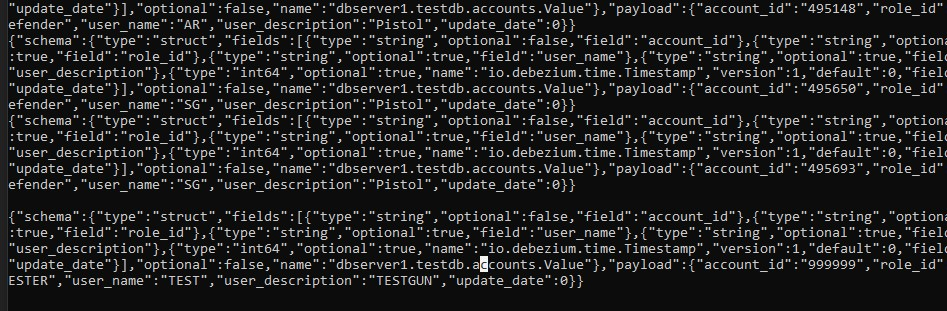

In [ ]:
같은 CSV 파일에 새로운 데이터를 추가하고 다시 CSV 파일은 넣어보았다.
커넥터는 읽었던곳 부터 읽어오는 특성을 가진다. 
그렇기에 이미 읽었던 CSV행은 무시하고 마지막 행만 추가로 읽어온 것을 볼 수 있음 

In [ ]:
Debezium Connector

Kafka Connect로 Flatfile sink 만들기

데이터 싱크(My SQL) -> 카프카 커텍트(Debezium Connector)



 -> Kafka -> 



 카프카 커넥트(JDBC Sink Connector)
 
  => 데이터 싱크 
 (Flatfile Sink)

In [ ]:
echo '{
  "name" : "my-first-sink",
  "config" : {
    "connector.class" : "org.apache.kafka.connect.file.FileStreamSinkConnector",
    "file" : "/root/test.txt",
    "topics" : "dbserver1.testdb.accounts"
  }
}
' | curl -X POST -d @- http://localhost:8083/connectors --header "content-Type:application/json"

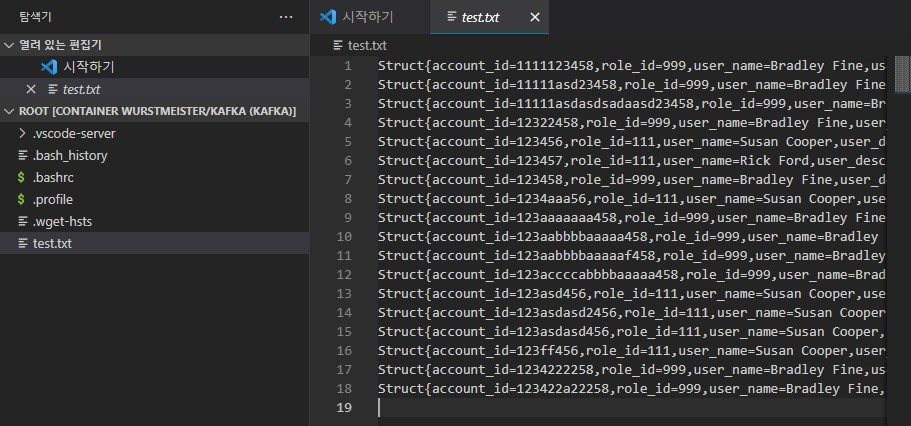